In [3]:
import cupy as cp

import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import rescale


/opt/conda/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


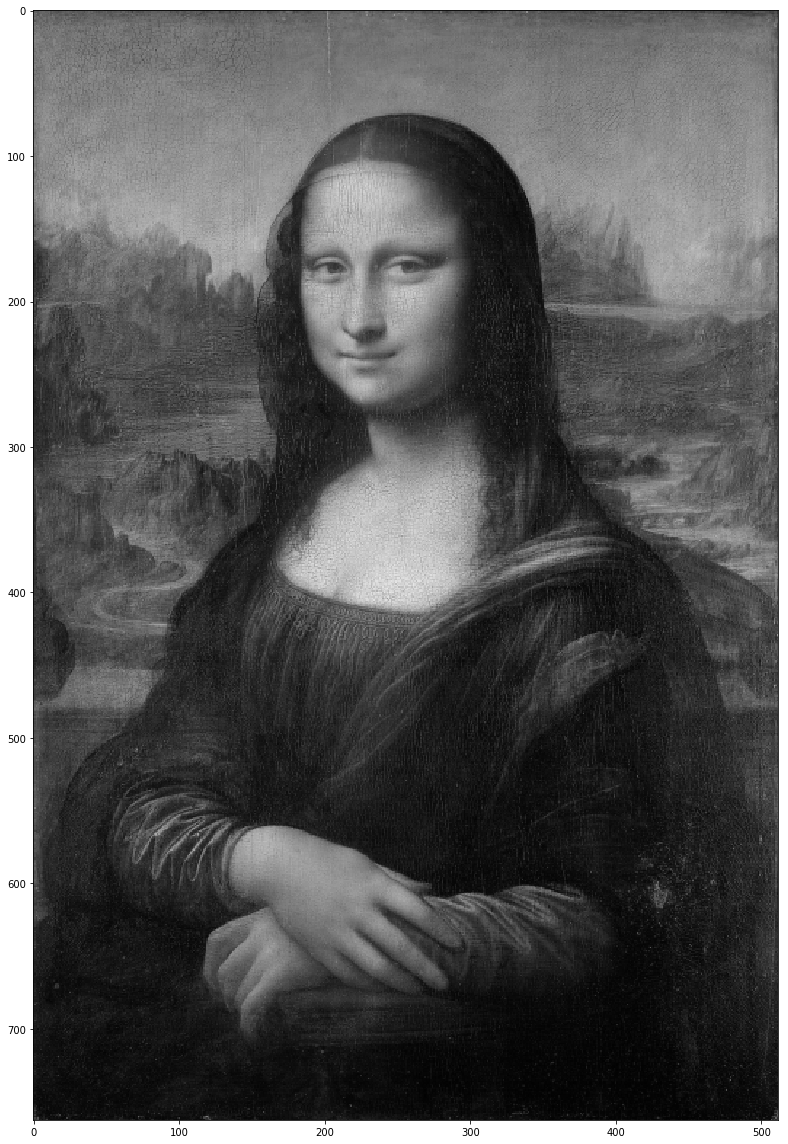

In [4]:
raw_image = io.imread("https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/1024px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg")
grayimage = rgb2gray(raw_image)
image = rescale(grayimage, 1.0 / 2.0, anti_aliasing=True, multichannel=False, mode='constant')
plt.figure(figsize=(16,16))
io.imshow(image, cmap='gray')

In [3]:
def genIr(h, w):
    return cp.random.rand(h,w, dtype=cp.float32)

def getBr(Ir, T):
    return cp.dot(Ir.ravel(), T.ravel()) / (T.shape[0] * T.shape[1])

def updateTgi(Tgi, Ir, Br, BrMean):
    coeff = Br - BrMean
    Tgi += Ir * coeff

def ghostImagingOnline(M, T):
    preM = 100000
    BrsMeanHat = cp.float32(0.0)
    for idx in range(preM):
        Ir = genIr(T.shape[0],T.shape[1])
        Br = getBr(Ir, T)
        BrsMeanHat += Br
    BrsMeanHat /= preM
    
    Tgi = cp.zeros(T.shape, dtype=cp.float32)
    for idx in range(M):
        Ir = genIr(T.shape[0],T.shape[1])
        Br = getBr(Ir, T)
        updateTgi(Tgi, Ir, Br, BrsMeanHat)
    return Tgi


CPU times: user 58 s, sys: 18 s, total: 1min 16s
Wall time: 1min 14s


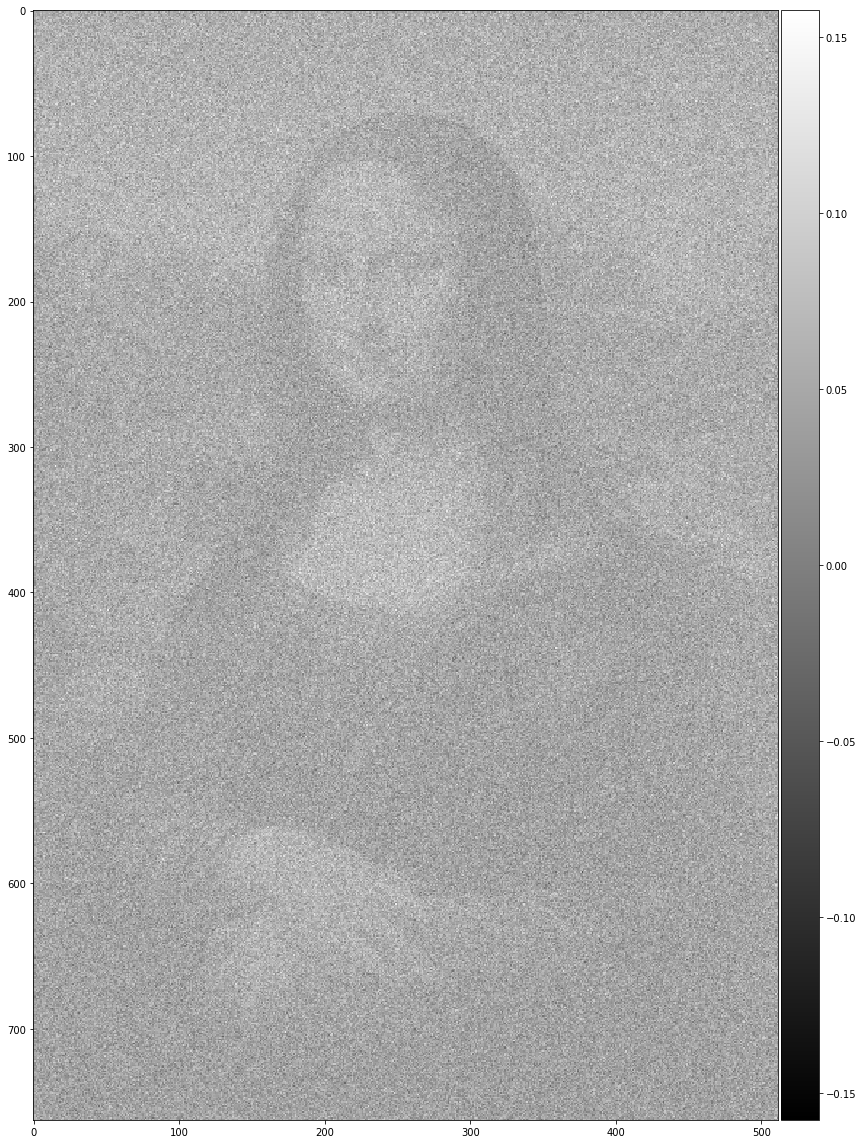

In [4]:
%%time
gi = ghostImagingOnline(M=200000, T=cp.asarray(image).astype(cp.float32))

plt.figure(figsize=(16,16))
io.imshow(cp.asnumpy(gi), cmap='gray')

In [7]:
# Processing in 1D 
def genIr(nPixels):
    return cp.random.rand(nPixels, dtype=cp.float32)

def getBr(Ir, T):
    return cp.dot(Ir, T) / len(T)

def updateTgi(Tgi, Ir, Br, BrMean):
    coeff = Br - BrMean
    Tgi += Ir * coeff

def ghostImagingOnline1D(M, T):
    T1D = T.ravel() # Processing in 1D
    nPixels = len(T1D)
    preM = 100000
    BrsMeanHat = cp.float32(0.0)
    for idx in range(preM):
        Ir = genIr(nPixels)
        Br = getBr(Ir, T1D)
        BrsMeanHat += Br
    BrsMeanHat /= preM
    
    Tgi = cp.zeros(nPixels, dtype=cp.float32)
    for idx in range(M):
        Ir = genIr(nPixels)
        Br = getBr(Ir, T1D)
        updateTgi(Tgi, Ir, Br, BrsMeanHat)
    return Tgi.reshape(T.shape)


CPU times: user 55.2 s, sys: 19.2 s, total: 1min 14s
Wall time: 1min 13s


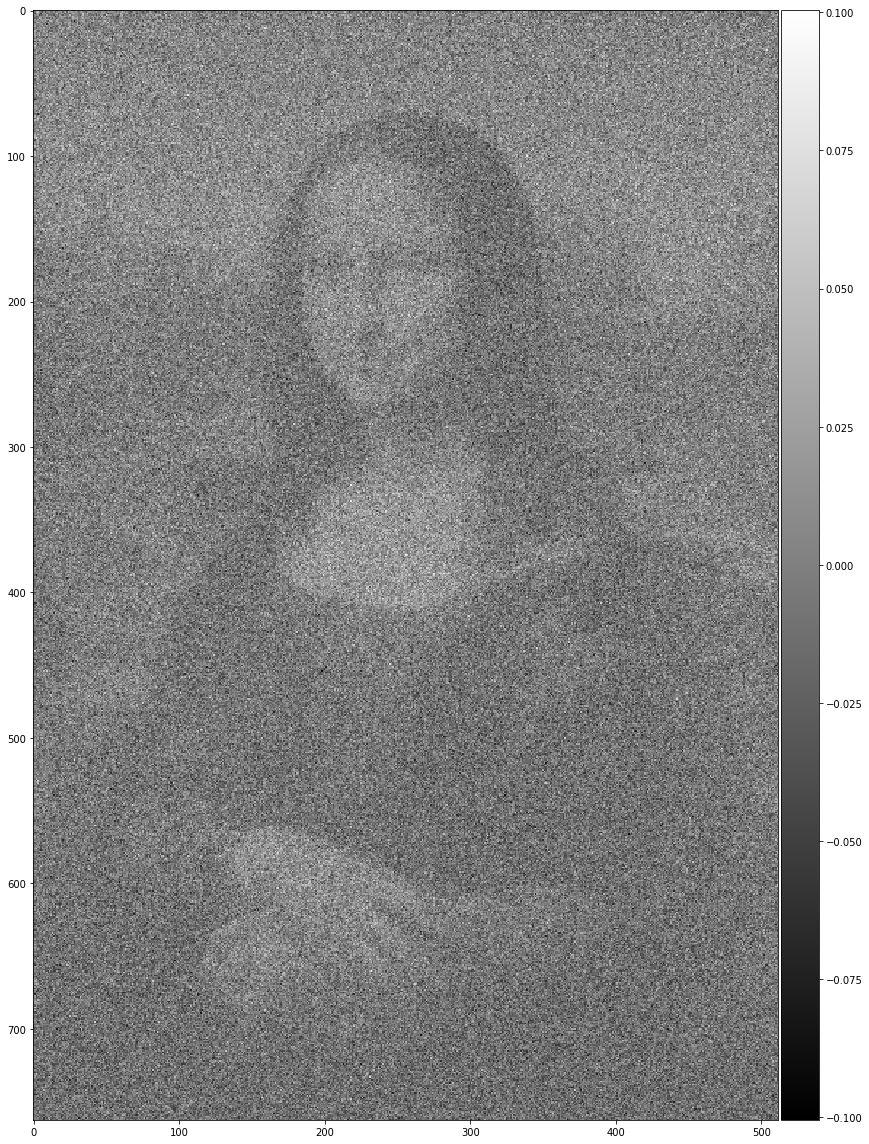

In [8]:
%%time
gi = ghostImagingOnline1D(M=200000, T=cp.asarray(image).astype(cp.float32))

plt.figure(figsize=(16,16))
io.imshow(cp.asnumpy(gi), cmap='gray')